# Applying Generalised Approach 
$L=\pi^TD^TD\pi+\lambda(1-\sum_i\pi_i)$ \
where \
$D_{\alpha, i}=\Delta f^{\mu(\alpha)}_i[t(\alpha)]$ 

# Set Up

In [101]:
import numpy as np
import seaborn as sns
from scipy.linalg import eig
import matplotlib.pyplot as plt 

from modules.LDS import Kalman_EM
from modules.WF_sim import *

from scipy.optimize import minimize
from scipy.optimize import nnls
from pathlib import Path

Total counts shape:  (3, 10)
A is not provide! A_demo is used.
(3, 20, 10)


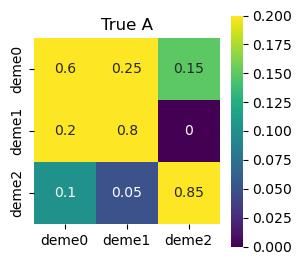

In [102]:
ND = 3 # the number of demes 
T=10 # the number of timepoints
Csn =[1.0]*ND # strength of measurement noise overdispersion
Npop = [1000]*ND # effective population size
if ND == 3:
    totcounts=np.array([[2000,3000,1500]]*T).T # number of sequences sampled from each region
elif ND > 3:
    totcounts = np.random.randint(1000, 3000, size=(ND, T))  # random counts for each deme at each timepoint
print("Total counts shape: ", totcounts.shape)

Ntraj = 20 # number of trajectories to simulate
A,counts,B=WF_sim(Npop, totcounts, Csn, ND, T, A=None, Ntraj=Ntraj)
print(counts.shape)
demes=['deme'+str(i) for i in range(ND)]

freqs = counts / (totcounts[:,None,:]) #calculating frequencies over all trajectories

plt.figure(figsize=[3,3])
sns.heatmap(A,cmap='viridis',vmax=0.2,annot=True,xticklabels=demes, yticklabels=demes,square=True)
plt.title('True A')
plt.show()

# find the lowest left eigenvector of A
eigvals, eigvecs = eig(A, left=True, right=False)
# normalize the eigenvectors
eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
eigvec_true = -eigvecs[:, np.argmax(eigvals.real)]
ordering = np.flip(np.argsort(eigvals.real))
eigvals = eigvals[ordering]
eigvecs = eigvecs[:,ordering]


In [103]:
#manufacturing the D matrix, and solving for initial pi values
def D_mat(freqs):
    ND, Ntraj, T = freqs.shape
    df_rows = []
    for mu in range(Ntraj):
        for t in range(T-1):
            delta_f=freqs[:,mu,t+1]-freqs[:,mu,t]
            df_rows.append(delta_f)
    D=np.stack(df_rows, axis=0)
    return D
def base_L(pi, freqs, lamb):
    D =D_mat(freqs)
    D_pi= D@ pi
    mat=D_pi.T @ D_pi
    L= mat + lamb*(1-np.sum(pi))

def grad_base_L(pi, freqs, lamb):
    D=D_mat(freqs)
    grad_L=2*(D.T @ D) @ pi - lamb
    return grad_L

def pi_finder_simple(freqs):
    ND, Ntraj, T = freqs.shape
    D=D_mat(freqs)
    one=np.ones(ND)
    lamb_inv=(one.T @ np.linalg.inv(D.T @ D) @ one)/2
    lamb=1/lamb_inv
    pi=lamb/2 * np.linalg.inv(D.T @ D) @ one
    return pi

pi_star=pi_finder_simple(freqs)
print(pi_star)

print(np.sum(pi_star))
print(totcounts.shape)

[0.3200088  0.42418671 0.25580449]
1.0
(3, 10)


# Attempt at Computing c 
$f_i^\mu(t) \approx \bar{f}_i^\mu(t) + \sqrt{\frac{c_i\bar{f}_i^\mu(t)}{S_{i,t}}} \eta_i^\mu(t)$ \
$F_i^\mu(t)=\frac{f_i^\mu(t+1)}{S_i(t+1)}+\frac{f_i^\mu(t)}{S_i(t)}$ \
$\beta_\alpha=(\pi \cdot \Delta f^{\mu(\alpha)}(t(\alpha)))^2 $ \
$\mathcal{F}_{\alpha,i}=\pi_i^2 F_i^{\mu(\alpha)}(t(\alpha))$  
\
$c=\mathcal{F}^+\beta$

In [104]:
#we now want to expand to be able to take noise and such in account

def F_setup(freqs, totcounts):
    ND, Ntraj, T=freqs.shape
    F=np.zeros((ND, Ntraj, T-1))
    df = np.zeros((ND, Ntraj, T-1))
    for i in range(ND):
        for u in range(Ntraj):
            for t in range(T-1):
                F[i,u,t]=freqs[i,u,t+1]/totcounts[i,t+1]+freqs[i,u,t]/totcounts[i,t]
                df[i,u,t]=freqs[i,u,t+1]-freqs[i,u,t]
    return F, df
F, df = F_setup(freqs, totcounts)
print (F.shape)

def F_fancy_setup(pi, freqs, totcounts):
    F, _=F_setup(freqs, totcounts)
    pi2=pi**2
    F_fancy=pi2[:,None,None]*F
    F_fancy = np.transpose(F_fancy, (1, 2, 0))  # (Ntraj, T-1, ND)
    F_fancy = F_fancy.reshape(-1, len(pi)) 
    return F_fancy
F_fancy=F_fancy_setup(pi_star, freqs, totcounts)
print(F_fancy.shape)

def beta_setup(pi, freqs, totcounts):
    _, df =F_setup(freqs, totcounts)
    df = np.transpose(df, (1,2,0)).reshape(-1, len(pi))
    dot=df @ pi
    beta= dot**2
    return beta


def c_finder(pi, freqs, totcounts):
    F_fancy=F_fancy_setup(pi, freqs, totcounts)
    beta=beta_setup(pi, freqs, totcounts)
    c=np.linalg.pinv(F_fancy)@beta
    c2=nnls(F_fancy, beta)
    return c, c2

c, c2=c_finder(pi_star, freqs, totcounts)

print (c)
print (c2)

(3, 20, 9)
(180, 3)
[2.2426192  1.60372351 1.27697066]
(array([2.2426192 , 1.60372351, 1.27697066]), np.float64(0.0005747828472773487))


In [105]:
lnLH_record, A_EM, Ne_EM, A_LS,Csn_EM=Kalman_EM(counts=counts+1, 
                                             counts_deme=totcounts, 
                                             em_step_max=100,terminate_th=0.001, 
                                             frac=0.5,noisemode=2,Qprintstep=False)


eigvals_LS, eigvecs_LS = eig(A_LS, left=True, right=False)
#eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
eigvec_LS = -eigvecs_LS[:, np.argmax(eigvals_LS.real)]
ordering = np.flip(np.argsort(eigvals_LS.real))
eigvals_LS = eigvals_LS[ordering]
eigvecs_LS = eigvecs_LS[:,ordering]
print (eigvec_LS/np.sum(eigvec_LS))
print(eigvec_true/np.sum(eigvec_true))
print(pi_star)

lnLH_record, A_EM, Ne_EM, A_LS,Csn_EM=Kalman_EM(counts=counts+1, 
                                             counts_deme=totcounts, 
                                             em_step_max=100,terminate_th=0.001, 
                                             frac=0.5,noisemode=2,Qprintstep=False)


eigvals_EM, eigvecs_EM = eig(A_EM, left=True, right=False)
#eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
eigvec_EM = -eigvecs_EM[:, np.argmax(eigvals_EM.real)]
ordering = np.flip(np.argsort(eigvals_EM.real))
eigvals_EM = eigvals_EM[ordering]
eigvecs_EM = eigvecs_EM[:,ordering]
print (eigvec_EM/np.sum(eigvec_EM))


terminate at step=14, DA=0.00014, ratioDNe=0.01109, ratioDCsn=0.02418
[0.29506785 0.41107163 0.29386052]
[0.28571429 0.42857143 0.28571429]
[0.3200088  0.42418671 0.25580449]
terminate at step=12, DA=0.00015, ratioDNe=0.01165, ratioDCsn=0.02491
[0.2658537  0.42595243 0.30819387]


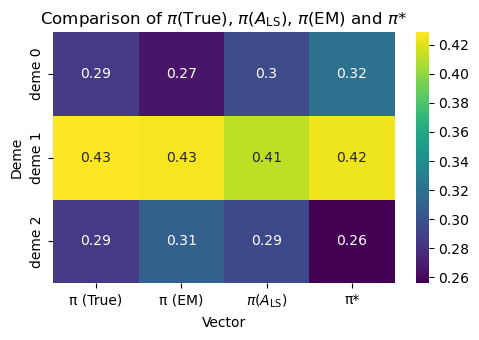

In [106]:
# Ensure real values
eigvec_real = np.real(eigvec_LS)
eigvec_true_real = np.real(eigvec_true)
eigvec_EM_real=np.real(eigvec_EM)
pi_star_real = np.real(pi_star)

# Normalize
eigvec_norm = eigvec_real / np.sum(eigvec_real)
eigvec_true_norm = eigvec_true_real / np.sum(eigvec_true_real)
eigvec_EM_norm = eigvec_EM_real / np.sum(eigvec_EM_real)
pi_star_norm = pi_star_real / np.sum(pi_star_real)

# Stack and transpose: shape (ND, 3)
data = np.vstack([eigvec_true_norm, eigvec_EM_norm, eigvec_norm, pi_star_norm]).T

# Labels
ylabels = [f'deme {i}' for i in range(len(pi_star))]
xlabels = ['π (True)', 'π (EM)', r'$\pi(A_{\mathrm{LS}})$', 'π*']

plt.figure(figsize=(5, len(pi_star) * 0.5 + 2))
sns.heatmap(data, annot=True, cmap='viridis', cbar=True, xticklabels=xlabels, yticklabels=ylabels)
plt.title(r'Comparison of $\pi$(True), $\pi(A_{\mathrm{LS}})$, $\pi$(EM) and $\pi$*')
plt.xlabel('Vector')
plt.ylabel('Deme')
plt.tight_layout()
plt.show()

In [107]:
#bootstrapping 
#essential idea of bootstrapping - trying to generate new data sets, same size as original, to create prob distribution of mean and s.d.
n_B = 1000 #number of bootstraps
def bootstrapping(freqs, n_B, seed=None): #paramterise by the frequency, number of bootstraps, and seed (used in random nummber generator)
    Nd, Ntraj, T = freqs.shape 
    numb=np.random.default_rng(seed) #ensures numbers are randomly generated all the time

    ps = [] #initialise list

    for b in range(n_B): #iterate over bootstrap numbers
        n_traj_new=numb.choice(Ntraj, size=Ntraj, replace=True) #generates a new array of random trajectories to use to 'shuffle around' frequencies
        freqs_bootstrap = freqs[:,n_traj_new,:] #creates bootstrapped frequency data sets

        #now run existing pi finder

        try: 
            pi_new = pi_finder_simple(freqs_bootstrap) #apply pi finder to new frequency
            ps.append(pi_new) #append list
        except Exception as e: #check for errors 
            print(f'{b} failed: {e}')
        if b % 100 == 0:
            print(f'Bootstrap {b}/{n_B}') #check for what stage we're at for large n_B
    ps=np.stack(ps) #turns list into matrix of pi vectors at differen boot straps

    

    ps_mean=np.mean(ps, axis=0) #gives the mean
    ps_std=np.std(ps, axis=0) #gives the standard deviation
    ps_lower=np.percentile(ps, 2.5, axis=0)
    ps_upper=np.percentile(ps, 97.5, axis=0) #gives confidence interva;
    return ps, ps_mean, ps_std, ps_lower, ps_upper

pis, pis_mean, pis_std, pis_lower, pis_upper = bootstrapping(freqs, n_B)
print (pis_mean)
print ("------")
print (pis_std)

Bootstrap 0/1000
Bootstrap 100/1000
Bootstrap 200/1000
Bootstrap 300/1000
Bootstrap 400/1000
Bootstrap 500/1000
Bootstrap 600/1000
Bootstrap 700/1000
Bootstrap 800/1000
Bootstrap 900/1000
[0.32145874 0.42576423 0.25277703]
------
[0.02166089 0.02592215 0.03035733]


<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
C:\Users\matty\AppData\Local\Temp\ipykernel_36796\932491609.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.hist(pis[:, i], bins=30, alpha=0.5, label=f"$\pi_{i}$", density=True)
C:\Users\matty\AppData\Local\Temp\ipykernel_36796\932491609.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(pi_star[i], color='k', linestyle='--', linewidth=2, label=f"$\pi^*_{{{i}}}$")
C:\Users\matty\AppData\Local\Temp\ipykernel_36796\932491609.py:8: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Bootstrap Distribution of $\pi_i$ Components')


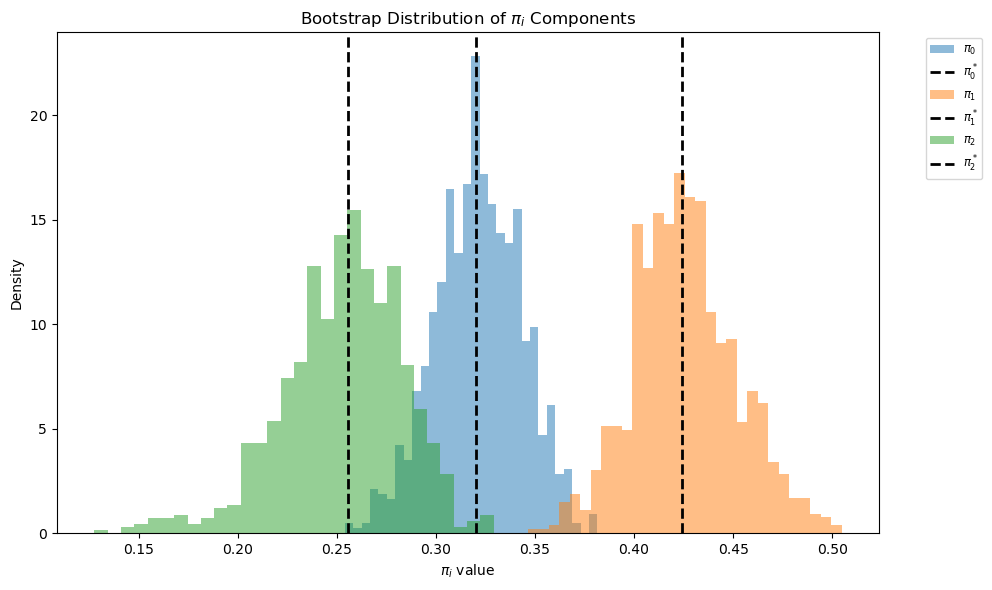

In [108]:
# pis shape: (n_B, ND)
plt.figure(figsize=(10, 6))
for i in range(pis.shape[1]):
    plt.hist(pis[:, i], bins=30, alpha=0.5, label=f"$\pi_{i}$", density=True)
    plt.axvline(pi_star[i], color='k', linestyle='--', linewidth=2, label=f"$\pi^*_{{{i}}}$")
plt.xlabel(r'$\pi_i$ value')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of $\pi_i$ Components')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()